# Key Takeaways

Chapter 4 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) discusses the capital asset pricing model (CAPM) and several multi-factor models.

***The key takeaways from this notebook are:***

1. Refreshing your knowledge on the CAPM, particularly how to interpret $\alpha$s and $\beta$s
1. Evaluating how well the CAPM predicts short-term and long-term returns
1. Implementing and interpreting multifactor models

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I love the topics in Lewinson.
However, I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

# Implementing the CAPM in Python

Lewinson clearly summarizes the capital asset pricing model (CAPM):

> In this recipe, we learn how to estimate the famous Capital Asset Pricing Model (CAPM) and obtain the beta coefficient. This model represents the relationship between the expected return on a risky asset and the market risk (also known as systematic or undiversifiable risk). CAPM can be considered a one-factor model, on top of which more complex factor models were built.
> 
> CAPM is represented by the following equation: $$E(r_i) = r_f + \beta_i (E(r_m) - r_f)$$
> 
> Here, $E(r_i)$ denotes the expected return on asset $i$, $r_f$ is the risk-free rate (such as a government bond), $E(r_m)$ is the expected return on the market, and $\beta_i$ is the beta coefficient.
>
> Beta can be interpreted as the level of the asset return's sensitivity, as compared to the market in general. Some possible examples include:
> 
> - $\beta <= -1$: The asset moves in the opposite direction as the benchmark and in a greater amount than the negative of the benchmark.
> - $-1 < \beta < 0$: The asset moves in the opposite direction to the benchmark.
> - $\beta = 0$: There is no correlation between the asset's price movement and the market benchmark.
> - $0 < \beta < 1$: The asset moves in the same direction as the market, but the amount is smaller. An example might be the stock of a company that is not very susceptible to day-to-day fluctuations.
> - $\beta = 1$: The asset and the market are moving in the same direction by the same amount.
> - $\beta > 1$: The asset moves in the same direction as the market, but the amount is greater. An example might be the stock of a company that is very susceptible to day-to-day market news.
>
> CAPM can also be represented: $$E(r_i) - r_f = \beta_i (E(r_m) - r_F)$$
>
> Here, the left-hand side of the equation can be interpreted as the risk premium, while the right-hand side contains the market premium. The same equation can be reshaped into: $$\beta_i = \frac{cov(R_i, R_m)}{var(R_m)}$$
>
> Here, $R_i = E(r_i) - r_f$ and $R_m = E(r_m) - r_f$.

We will follow Lewinson's layout, but change his syntax to match the syntax we use elsewhere in the course.
To move beyond the CAPM, we need the statsmodels package for linear regressions and rolling linear regressions.
We will use statsmodels' formula API (advanced programming interface) to match R's regression formulas.

In [4]:
import statsmodels.formula.api as smf

We will also estimate the CAPM for Amazon (AMZN), but we will not limit our data download.

In [5]:
amzn = yf.download(tickers='AMZN', session=session)

[*********************100%***********************]  1 of 1 completed


Lewinson uses the S&P 500 index from Yahoo! Finance (ticker `^GSPC`) as his market return.
`^GSPC` is not a total return index, so it excludes dividends and is incorrect for CAPM estimations.
Instead, we will use Ken French's `Mkt-RF`, which is the excess return on the total market.
Ken French also provides the risk-free rate (`RF`).
Note that we specify an early start date to download and parse all available data.

In [6]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)

Note:

- `ff` is a dictionary
- the `0` item is the data frame of returns
- the `DESCR` item is the data description
- the `Mkt-RF` column name is difficult to use because the `-` confuses some functions and methods
- returns are in percents instead of decimals

We will modify `ff` to fix these problems name columns to match Lewinson's formulas above.

In [7]:
print(ff['DESCR'])

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202206 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2022 Kenneth R. French

  0 : (25272 rows x 4 cols)


In [8]:
amzn = amzn.join(ff[0], how='inner')

In [9]:
amzn.rename(columns={'Mkt-RF': 'Rm', 'RF': 'rf'}, inplace=True)

We will also estimate $\beta$s from daily data.
It is optimal to estimate $\beta$s from one to three years of daily data.
Note, we are keeping returns in percent, so we multiply `.pct_change()` by 100.

In [10]:
amzn['ri'] = 100 * amzn['Adj Close'].pct_change()

In [11]:
amzn.eval('Ri = ri - rf', inplace=True)

First, we can estimate $\beta_i$ with the covariance approach: 

In [12]:
cov = amzn.loc['2020-08-08':, ['Ri', 'Rm']].cov()

In [13]:
cov

,Ri,Rm
Ri,5.1804,1.9672
Rm,1.9672,1.4206


Because $var(R_m) = cov(R_m, R_m)$, we do not need to recalculate the market variance.

In [14]:
beta = cov.loc['Ri', 'Rm'] / cov.loc['Rm', 'Rm']

In [15]:
'AMZN beta: {:0.4f}'.format(beta)

'AMZN beta: 1.3848'

Second, we can estimate $\beta_i$ with a linear regression, and we will use statsmodels' formula API.
Note that we multiply the data 100 to convert decimal returns to percent.
This scaling does not affect the megnitude of the systematic risk measure $\beta$, but it converts the intercept coefficient estimate $\alpha$ percent, making it easier to interpret.

In [16]:
capm_model = smf.ols(formula='Ri ~ Rm', data=amzn.loc['2020-08-08':]).fit()
capm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     526.8
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           5.39e-79
Time:                        18:15:18   Log-Likelihood:                -890.66
No. Observations:                 477   AIC:                             1785.
Df Residuals:                     475   BIC:                             1794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1009      0.072     -1.404      0.161      -0.242       0.040
Rm             1.3848      0.060     22.952      0.000       1.266       1.503
==============================================================================
Omnibus:                      135.176   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2569.626
Skew:                           0.698   Prob(JB):                         0.00
Kurtosis:                      14.285   Cond. No.                         1.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

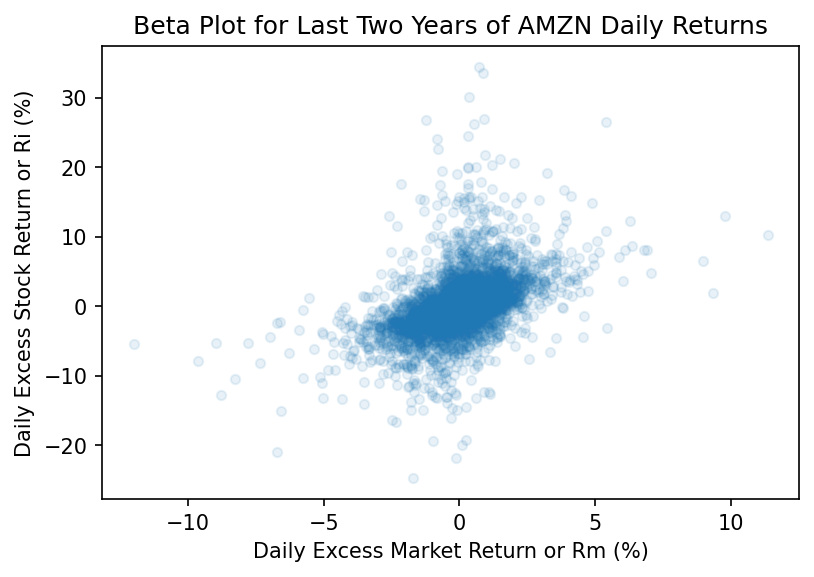

In [17]:
amzn[['Ri', 'Rm']].plot(x='Rm', y='Ri', kind='scatter', alpha=0.1)
plt.xlabel('Daily Excess Market Return or Rm (%)')
plt.ylabel('Daily Excess Stock Return or Ri (%)')
plt.title('Beta Plot for Last Two Years of AMZN Daily Returns')
plt.show()

We can also use `regplot()` from the seaborn package.

In [18]:
import seaborn as sns

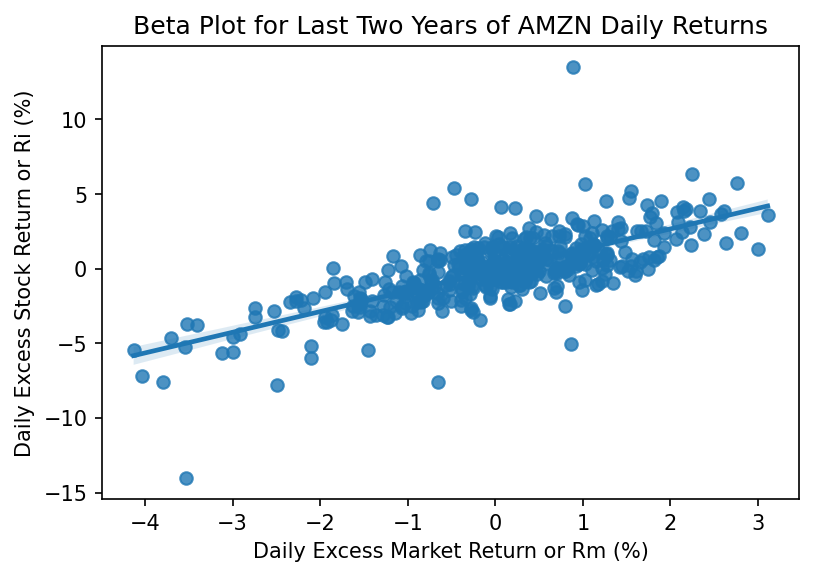

In [19]:
sns.regplot(x='Rm', y='Ri', data=amzn.loc['2020-08-08':])
plt.xlabel('Daily Excess Market Return or Rm (%)')
plt.ylabel('Daily Excess Stock Return or Ri (%)')
plt.title('Beta Plot for Last Two Years of AMZN Daily Returns')
plt.show()

# Does the CAPM predict long-term returns?

Does the CAPM predict long-term returns?
We expect high $\beta$ stocks to have high future returns.
We can see how well this model works by analyzing the returns on portfolios formed on $\beta$.
Ken French provides these data.

In [20]:
# pdr.famafrench.get_available_datasets()

In [21]:
ff_beta_0 = pdr.get_data_famafrench('Portfolios_Formed_on_BETA', start='1900', session=session)

In [22]:
print(ff_beta_0['DESCR'])

Portfolios Formed on BETA
-------------------------

This file was created by CMPT_BETA_RETS using the 202206 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BETA. The portfolios are constructed at the end of June. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2022 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (708 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (708 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (58 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (58 rows x 15 cols)
  4 : Number of Firms in Portfolios (708 ro

In [23]:
ff_beta = ff_beta_0[2].iloc[:, :5]

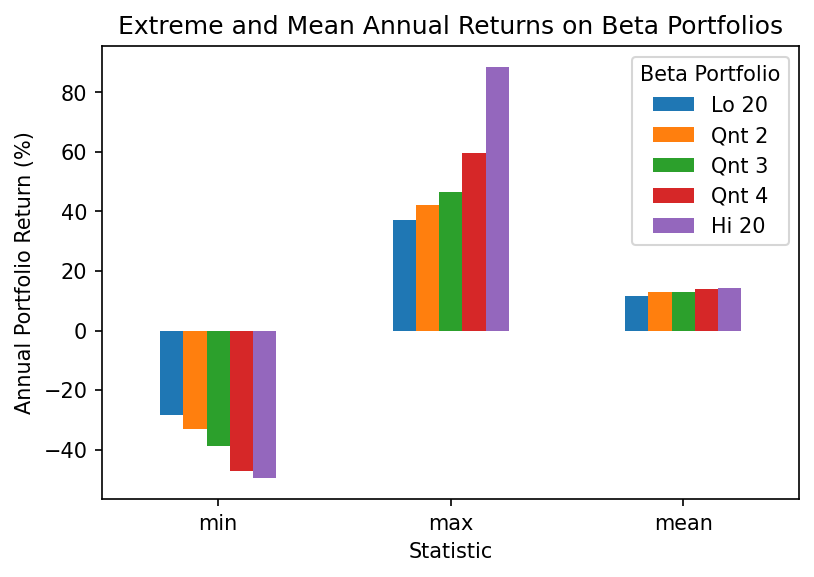

In [24]:
ff_beta.agg(['min', 'max', 'mean']).plot(kind='bar', rot=0)
plt.ylabel('Annual Portfolio Return (%)')
plt.xlabel('Statistic')
plt.legend(title='Beta Portfolio')
plt.title('Extreme and Mean Annual Returns on Beta Portfolios')
plt.show()

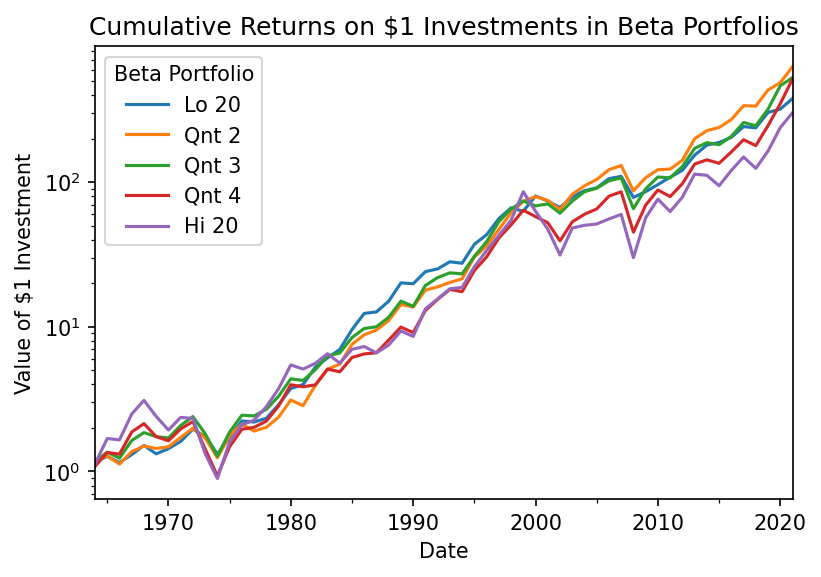

In [25]:
ff_beta.div(100).add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of $1 Investment')
plt.legend(title='Beta Portfolio')
plt.title('Cumulative Returns on $1 Investments in Beta Portfolios')
plt.show()

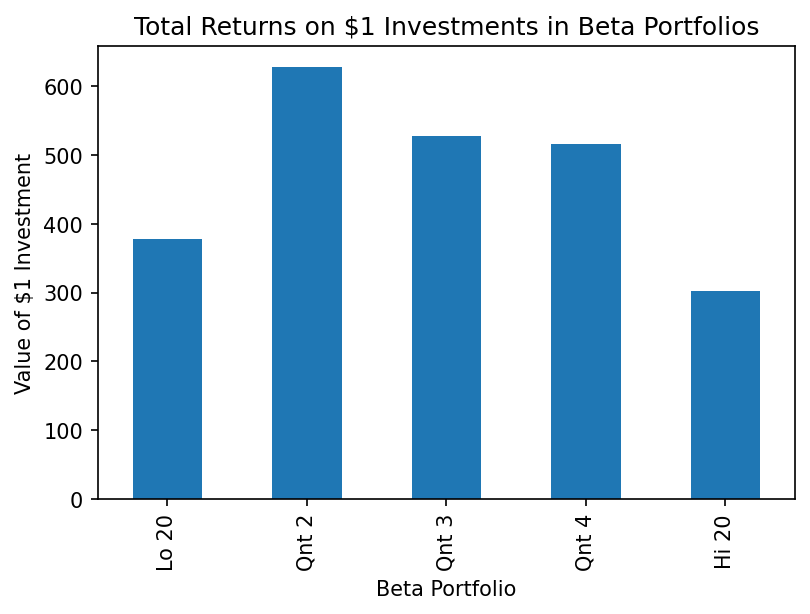

In [26]:
ff_beta.div(100).add(1).prod().plot(kind='bar')
plt.ylabel('Value of $1 Investment')
plt.xlabel('Beta Portfolio')
plt.title('Total Returns on $1 Investments in Beta Portfolios')
plt.show()

To estimate Sharpe Ratios correctly, we need convert these beta portfolio returns to *excess* returns.

In [27]:
ff_alt = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1900', session=session)

In [28]:
print(ff_alt['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202206 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2022 Kenneth R. French

  0 : (1152 rows x 4 cols)
  1 : Annual Factors: January-December (95 rows x 4 cols)


In [29]:
ff_beta_excess = ff_beta.sub(ff_alt[1]['RF'], axis=0)

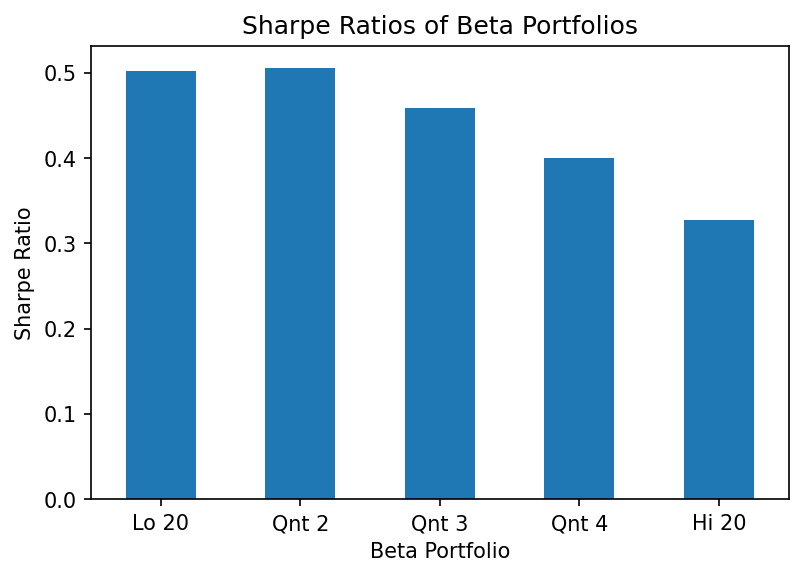

In [30]:
(ff_beta_excess.mean() / ff_beta_excess.std()).plot(kind='bar', rot=0)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Beta Portfolio')
plt.title('Sharpe Ratios of Beta Portfolios')
plt.show()

# Implementing the Fama-French three-factor model in Python

Lewinson clearly summarizes the Fama and French three factor model:

> In their famous paper, Fama and French expanded the CAPM model by adding two additional factors explaining the excess returns of an asset or portfolio. The factors they considered are:
> 
> - The market factor (MKT): It measures the excess return of the market, analogical to the one in the CAPM.
> - The size factor, SMB (Small Minus Big): It measures the excess return of stocks with a small market cap over those with a large market cap.
> - The value factor, HML (High Minus Low): It measures the excess return of value stocks over growth stocks. Value stocks have a high book-to-market ratio, while the growth stocks are characterized by a low ratio.
> 
> The model can be represented as follows: $$E(r_i) = r_f + \alpha + \beta_{mkt} (E(r_m) - r_f) + \beta_{SMB} SMB + \beta_{HML} HML$$
> 
> Or in its simpler form: $$E(r_i) - r_f = \alpha + \beta_{mkt} (E(r_m) - r_f) + \beta_{SMB} SMB + \beta_{HML} HML$$
> 
> Here, $E(r_i)$ denotes the expected return on asset $i$, $r_f$ is the risk-free rate (such as a government bond), and $\alpha$ is the intercept. The reason for including the constant intercept is to make sure its value is equal to 0. This confirms that the three-factor model evaluates the relationship between the excess returns and the factors correctly.
> In the case of a statistically significant, non-zero intercept, the model might not evaluate the asset/portfolio return correctly. However, the authors stated that the three-factor model is "fairly correct", even when it is unable to pass the statistical test.
> 
> Due to the popularity of this approach, these factors became collectively known as the Fama-French Factors, or the Three-Factor Model. They have been widely accepted in both academia and the industry as stock market benchmarks and they are often used to evaluate investment performance.

Lewinson uses new data to implement the Fama and French three-factor model, but we can use the same Amazon data from above to save ourselves some time and memory.
As with CAPM estimations, we should estimate the three-factor model with one to three years of daily data.

There are two common uses for the three-factor model:

1. Use the coefficient estimate on the intercept (i.e., $\alpha$  often called "Jensen's $\alpha$") as a risk-adjusted performance measure. If $\alpha$ is positive and statistically significant, we may attribute a fund manager's performance to skill.
2. Use the remaining coefficient estimates to evaluate how the fund manager generates returns. If the regression $R^2$ is high, we may replace the fund manager with the factor itself.

---

***Practice:***
Estimate the three-factor model for Amazon with the most recent two years of daily returns data.

In [31]:
ff3_model = smf.ols(formula='Ri ~ Rm + SMB + HML', data=amzn.loc['2020-08-08':]).fit()
ff3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     269.9
Date:                Wed, 10 Aug 2022   Prob (F-statistic):          4.83e-102
Time:                        18:15:21   Log-Likelihood:                -830.73
No. Observations:                 477   AIC:                             1669.
Df Residuals:                     473   BIC:                             1686.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0487      0.064     -0.765      0.445      -0.174       0.076
Rm             1.2657      0.059     21.438      0.000       1.150       1.382
SMB           -0.4273      0.085     -5.011      0.000      -0.595      -0.260
HML           -0.5437      0.052    -10.404      0.000      -0.646      -0.441
==============================================================================
Omnibus:                      189.508   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6104.037
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                      20.398   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above, the coefficient on the market risk premium (`Rm`) is greater than one, indicating that AMZN has greater than average systematic risk.
The average stock has a market beta of one by construction.
The coefficient on SMB (i.e., small-minus-big) is significantly negative, indicating that AMZN has a negative exposure to the small-stock risk factor because AMZN is a big stock (i.e., has a big market capitalization).
Finally, the coefficient on HML is significantly negative, indicating that AMZN has a negative exposure to the value-stock risk factor because AMZN is a growth stock with high P/E (price/earnings) and low B/M (book-to-market equity ratio).

We can look at AMZN's first two years to see how AMZN has changed.

In [32]:
smf.ols(formula='Ri ~ Rm + SMB + HML', data=amzn.loc[:'1999-05']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     43.28
Date:                Wed, 10 Aug 2022   Prob (F-statistic):           6.31e-25
Time:                        18:15:21   Log-Likelihood:                -1608.7
No. Observations:                 513   AIC:                             3225.
Df Residuals:                     509   BIC:                             3242.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7313      0.248      2.951      0.003       0.244       1.218
Rm             1.8405      0.346      5.317      0.000       1.160       2.521
SMB            0.8110      0.429      1.892      0.059      -0.031       1.653
HML           -1.5671      0.658     -2.381      0.018      -2.860      -0.274
==============================================================================
Omnibus:                       42.952   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.404
Skew:                           0.539   Prob(JB):                     2.57e-17
Kurtosis:                       4.554   Cond. No.                         3.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Above, we see that shortly after its initial public offering (IPO), AMZN had more systematic risk (i.e., higher coefficient on `Rm`), positive exosure to small-stock risk (i.e., higher coefficient on SMB), and even more negative expsoure to value-stock risk (i.e., even more negative coefficient on HML).

Next, if we repeat this exercise for the inverse triple levered exchange traded fund (ETF) [SPXU](https://finance.yahoo.com/quote/SPXU), we expect $\alpha \approx 0$ and $\beta \approx -3$.

In [33]:
spxu = yf.download(tickers='SPXU', session=session)
spxu = spxu.join(ff[0])
spxu.rename(columns={'Mkt-RF': 'Rm', 'RF': 'rf'}, inplace=True)
spxu['ri'] = spxu['Adj Close'].pct_change().mul(100)
spxu.eval('Ri = ri - rf', inplace=True)

smf.ols(formula='Ri ~ Rm + SMB + HML', data=spxu.loc['2020-08-08':]).fit().summary()

[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        18:15:21   Log-Likelihood:                -122.87
No. Observations:                 477   AIC:                             253.7
Df Residuals:                     473   BIC:                             270.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0133      0.014     -0.920      0.358      -0.042       0.015
Rm            -2.9392      0.013   -219.567      0.000      -2.965      -2.913
SMB            0.4817      0.019     24.917      0.000       0.444       0.520
HML           -0.1464      0.012    -12.359      0.000      -0.170      -0.123
==============================================================================
Omnibus:                        2.948   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                3.268
Skew:                           0.013   Prob(JB):                        0.195
Kurtosis:                       3.405   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can make a general function that downloads and combines data and prepares a three-factor model.

In [34]:
def ff3_mod(ticker='BRK-A', start='1900', stop='2022', ff=ff[0]):
    ret = yf.download(tickers=ticker, session=session)[['Adj Close']].pct_change().mul(100)
    ret = ret.join(ff, how='inner')
    ret.rename(columns={'Adj Close': 'ri', 'Mkt-RF': 'Rm', 'RF': 'rf'}, inplace=True)
    ret.eval('Ri = ri - rf', inplace=True)

    mod = smf.ols(formula='Ri ~ Rm + SMB + HML', data=ret.loc[start:stop])
    
    return {'mod': mod, 'ret': ret} # returns un-fit model and full data

[*********************100%***********************]  1 of 1 completed


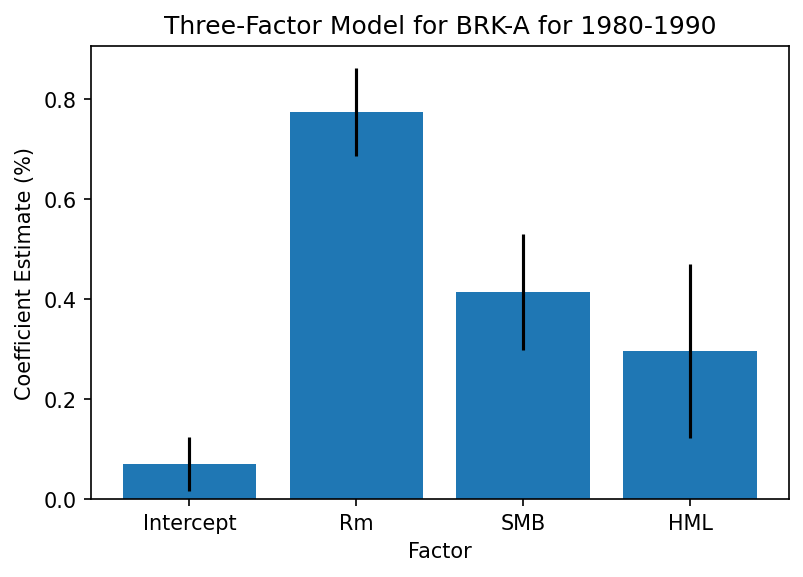

In [35]:
brka = ff3_mod(ticker='BRK-A', start='1980', stop='1990')['mod']
brka_fit = brka.fit()
plt.bar(x=brka_fit.params.index, height=brka_fit.params, yerr=2*brka_fit.bse)
plt.ylabel('Coefficient Estimate (%)')
plt.xlabel('Factor')
plt.title('Three-Factor Model for BRK-A for 1980-1990')
plt.show()

Above, we see that BRK-A has a significantly positive alpha or $\alpha$, which is the coefficient on the intercept.
A significantly positive alpha suggests a fund manager has skill.
Here Buffett's alpha seems small, but these are daily returns data, and this alpha annualizes to around 25% per year for this 11-year period.

[*********************100%***********************]  1 of 1 completed


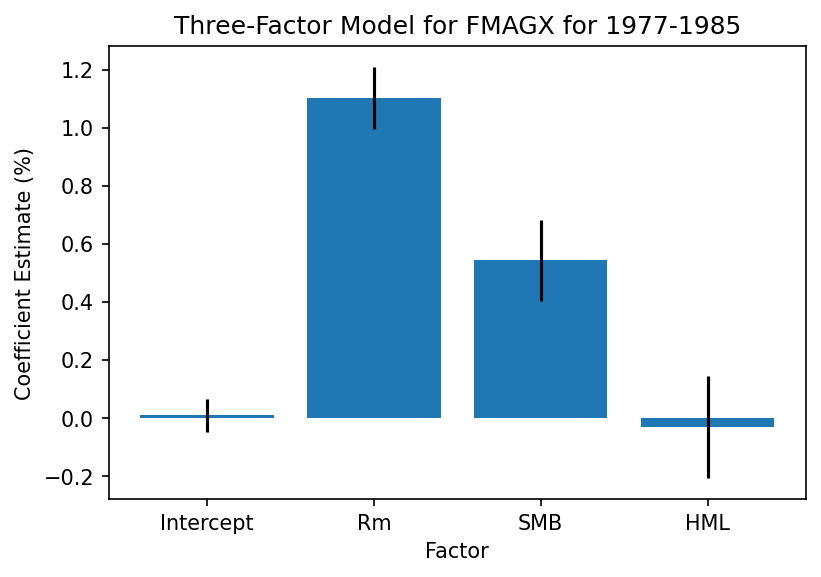

In [36]:
fmagx = ff3_mod(ticker='FMAGX', start='1977', stop='1985')
fmagx_fit = fmagx['mod'].fit()
plt.bar(x=fmagx_fit.params.index, height=fmagx_fit.params, yerr=2*fmagx_fit.bse)
plt.ylabel('Coefficient Estimate (%)')
plt.xlabel('Factor')
plt.title('Three-Factor Model for FMAGX for 1977-1985')
plt.show()

Peter Lynch managed FMAGX (Fidelity's Magellan Fund) from the late 1970s through 1990.
He does not appear to have alpha over this full sample, but he generated substantial returns through market and small-stock risk.

# Implementing the rolling three-factor model on a portfolio of assets

Lewinson manually estimates rolling three-factor regressions.
However, statsmodels estimates rolling regressions out of the box!

In [37]:
from statsmodels.regression.rolling import RollingOLS

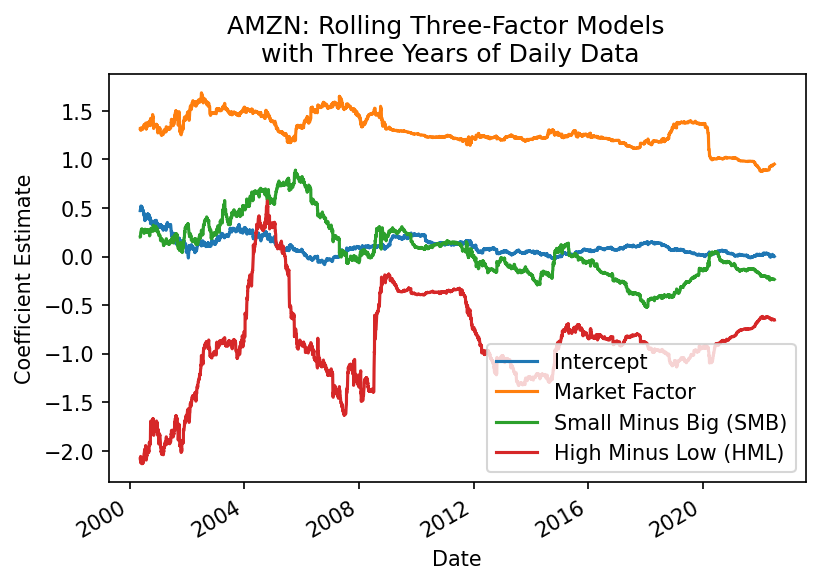

In [38]:
_ = RollingOLS.from_formula('Ri ~ Rm + SMB + HML', data=amzn, window=3*252).fit().params
_.plot()
plt.legend(['Intercept', 'Market Factor', 'Small Minus Big (SMB)', 'High Minus Low (HML)'])
plt.ylabel('Coefficient Estimate')
plt.suptitle('AMZN: Rolling Three-Factor Models\n with Three Years of Daily Data')
plt.show()

---

***Practice:***
Repeat the exercise above with Berkshire Hathaway (ticker BRK-A).
What does the plot tell us about Warren Buffet's skill as an asset manager?

Here we use the `ff3_mod()` function but just to download and combine data.

[*********************100%***********************]  1 of 1 completed


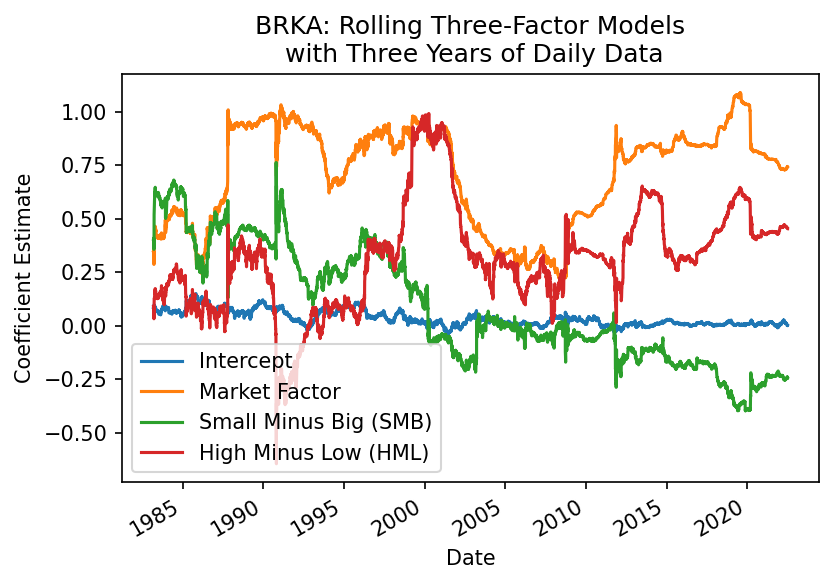

In [39]:
brka = ff3_mod(ticker='BRK-A', start='1980', stop='1990')
brka_ret = brka['ret']
_ = RollingOLS.from_formula('Ri ~ Rm + SMB + HML', data=brka_ret, window=3*252).fit().params
_.plot()
plt.legend(['Intercept', 'Market Factor', 'Small Minus Big (SMB)', 'High Minus Low (HML)'])
plt.ylabel('Coefficient Estimate')
plt.title('BRKA: Rolling Three-Factor Models\n with Three Years of Daily Data')
plt.show()

---

# Implementing the four- and five-factor models in Python

There are literally hundreds of published factors!
However, many of them have little explanatory power (in or out of sample.
Two more factor models that have explanatory power and economic intuition are the four- and five-factor models.
The four-factor model is from Carhartt and the five-factor model is from Fama and French.

> In this recipe, we implement two extensions of the Fama-French three-factor model.
> 
> Carhart's Four-Factor model: The underlying assumption of this extension is that, within a short period of time, a winner stock will remain a winner, while a loser will remain a loser. An example of a criterion for classifying winners and losers could be the last 12-month cumulative total returns. After identifying the two groups, we long the winners and short the losers within a certain holding period.
> 
> The momentum factor (WML; Winners Minus Losers) measures the excess returns of the winner stocks over the loser stocks in the past 12 months (please refer to the See also section of this recipe for references on the calculations of the momentum factor).
> 
> The four-factor model can be expressed: $$E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{HML}HML + \beta_{wml}WML$$
> 
> Fama-French's Five-Factor model: Fama and French expanded their three-factor model by adding two factors:
> 
> - Robust Minus Weak (RMW) measures the excess returns of companies with high profit margins (robust profitability) over those with lower profits (weak profitability).
> - Conservative Minus Aggressive (CMA) measures the excess returns of firms with low investment policies (conservative) over those investing more (aggressive).
> 
> The five-factor model can be expressed as follows: $$E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{HML}HML + \beta_{rmw}RMW + \beta_{cma}CMA$$
> 
> Like in all factor models, if the exposure to the risk factors captures all possible variations in expected returns, the intercept (α) for all the assets/portfolios should be equal to zero.


---

***Practice:***
Estimate four-factor and five-factor models for Berkshire Hathaway (ticker BRK-A) for the 1980s and 1990s.
Plot the coefficient estimates from each model.
What do these plots say about how Warren Buffett generate returns?

With this task in hand, maybe we should write a general function for data and general function for factor models.
We have to add some tricks here, like stripping whitespace from the `Mom` name in the momentum (or winners-minus-losers or up-minus-down) column.
Also, `tickers` can be a single ticker or a list of tickers.
If `tickers` is a single ticker, then `returns` is a series and we have to convert it to a data frame to join it to the factors.

In [40]:
def get_data(tickers=None):
    ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900', session=session)
    mom = pdr.get_data_famafrench('F-F_Momentum_Factor_daily', start='1900', session=session)
    ff5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily', start='1900', session=session)
    factors = ff[0].join(mom[0], how='outer').join(ff5[0][['RMW', 'CMA']])
    factors.columns = factors.columns.str.replace(' ','') # the Mom column name is padded with whitespace
    if tickers is not None:
        returns = yf.download(tickers=tickers, session=session)['Adj Close'].pct_change().mul(100)
        if isinstance(returns, pd.Series):
            returns.to_frame(tickers)
        return returns.join(factors, how='outer')
    else:
        return factors

In [41]:
df = get_data(tickers=['AAPL', 'BRK-A'])

[*********************100%***********************]  2 of 2 completed


In [42]:
df.head()

,AAPL,BRK-A,Mkt-RF,SMB,HML,RF,Mom,RMW,CMA
Date,,,,,,,,,
1926-07-01,NaN,NaN,0.1000,-0.2300,-0.2800,0.0090,NaN,NaN,NaN
1926-07-02,NaN,NaN,0.4500,-0.3400,-0.0300,0.0090,NaN,NaN,NaN
1926-07-06,NaN,NaN,0.1700,0.2900,-0.3800,0.0090,NaN,NaN,NaN
1926-07-07,NaN,NaN,0.0900,-0.5900,0.0000,0.0090,NaN,NaN,NaN
1926-07-08,NaN,NaN,0.2100,-0.3800,0.1800,0.0090,NaN,NaN,NaN


Formulas are typically the best way to specify regression models.
However, we can also pass the "y" variable (i.e., the excess returns) to the `endog` argument and the "X" variable (i.e., the factors and intercept or constant) to the `exog` argument.

In [43]:
import statsmodels.api as sma

In [44]:
def get_model(data, ticker, factors=['Mkt-RF']):
    _data = data[[ticker, 'RF'] + factors].dropna()
    mod = sma.OLS(
        endog=_data[ticker] - _data['RF'],
        exog=sma.add_constant(_data[factors])
    )
    return mod

In [45]:
get_model(data=df, ticker='BRK-A').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     3126.
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        18:15:33   Log-Likelihood:                -17646.
No. Observations:               10663   AIC:                         3.530e+04
Df Residuals:                   10661   BIC:                         3.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0416      0.012      3.392      0.001       0.018       0.066
Mkt-RF         0.6186      0.011     55.915      0.000       0.597       0.640
==============================================================================
Omnibus:                     2514.645   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38762.842
Skew:                           0.712   Prob(JB):                         0.00
Kurtosis:                      12.231   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
get_model(data=df, ticker='BRK-A', factors=['Mkt-RF', 'SMB', 'HML', 'Mom']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     917.7
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        18:15:33   Log-Likelihood:                -17439.
No. Observations:               10663   AIC:                         3.489e+04
Df Residuals:                   10658   BIC:                         3.493e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0345      0.012      2.863      0.004       0.011       0.058
Mkt-RF         0.6510      0.011     58.251      0.000       0.629       0.673
SMB            0.0078      0.020      0.381      0.703      -0.032       0.048
HML            0.4037      0.020     19.822      0.000       0.364       0.444
Mom            0.0407      0.016      2.623      0.009       0.010       0.071
==============================================================================
Omnibus:                     2521.149   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40079.712
Skew:                           0.705   Prob(JB):                         0.00
Kurtosis:                      12.393   Cond. No.                         2.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
get_model(data=df, ticker='BRK-A', factors=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     737.9
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        18:15:33   Log-Likelihood:                -17432.
No. Observations:               10663   AIC:                         3.488e+04
Df Residuals:                   10657   BIC:                         3.492e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0395      0.012      3.275      0.001       0.016       0.063
Mkt-RF         0.6269      0.012     52.116      0.000       0.603       0.650
SMB           -0.0280      0.022     -1.286      0.199      -0.071       0.015
HML            0.3984      0.022     17.815      0.000       0.355       0.442
RMW           -0.1357      0.031     -4.405      0.000      -0.196      -0.075
CMA           -0.0345      0.038     -0.898      0.369      -0.110       0.041
==============================================================================
Omnibus:                     2470.233   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39773.859
Skew:                           0.677   Prob(JB):                         0.00
Kurtosis:                      12.364   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""